# Comparación BFGS: scipy vs implementación

In [1]:
import numpy as np
import numpy.linalg as ln
import scipy as sp
import scipy.optimize
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

In [2]:
path_for_imgs = '../Reporte/imgs/'

### Visualización

Si bien el objetivo principal del proyecto es implementar BFGS y resolver el problema, incluimos un poco de visualización inicial de los datos solo para ver con qué estamos trabajando.

In [3]:
# Leer los datos, pasarlos a pandas
orig = pd.read_csv("../Datos/healthcare-dataset-stroke-data.csv")

# Imprimirlos para saber con que trabajamos
orig

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
...,...,...,...,...,...,...,...,...,...,...,...,...
5105,18234,Female,80.0,1,0,Yes,Private,Urban,83.75,NaN,never smoked,0
5106,44873,Female,81.0,0,0,Yes,Self-employed,Urban,125.20,40.0,never smoked,0
5107,19723,Female,35.0,0,0,Yes,Self-employed,Rural,82.99,30.6,never smoked,0
5108,37544,Male,51.0,0,0,Yes,Private,Rural,166.29,25.6,formerly smoked,0


Definimos algunas funciones que nos servirán para plotear:

In [4]:
quitar_marco = lambda ax : [ax.spines[spine].set_visible(False) 
                            for spine in ax.spines if spine not in ['bottom']]
    
def histograma(var, ax):
    ax.hist(orig[var], align='left')
    ax.tick_params(labelsize = 12)
    quitar_marco(ax)
    ax.set_title(var, fontsize = 14)
    plt.xticks(rotation = 30)    

def barras(var, ax):
    aux = orig.groupby(var).count()['id']
    ax.bar(aux.index, aux)
    ax.tick_params(labelsize = 12)
    quitar_marco(ax)
    ax.set_title(var, fontsize = 14)
    plt.xticks(rotation = 30)

La variable objetivo es **stroke**, que indica si el paciente tuvo o no un ataque cardiaco:

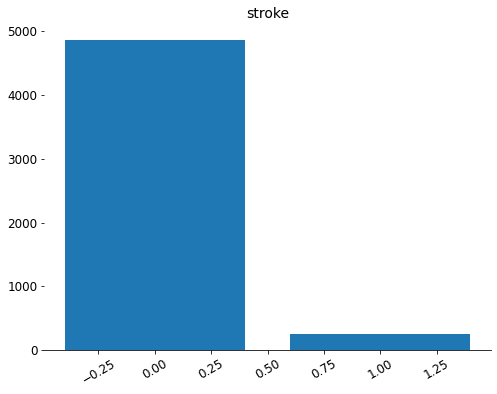

In [5]:
fig, ax = plt.subplots(figsize = (8, 6))
barras('stroke', ax)

Las variables predictoras son características de las personas, como su edad (**age**), si ha tenido alguna enfermedad de corazón (**heart_disease**), su nivel promedio de glucosa (**avg_glucose_level**), entre otra:

In [6]:
axxxs = {'gender': (0, 0, barras),
         'age': (0, 1, histograma), 
         'hypertension': (1, 0, barras), 
         'heart_disease': (1, 1, barras),
         'ever_married': (2, 0, barras), 
         'work_type': (4, 0, barras), 
         'Residence_type': (3, 0, barras), 
         'avg_glucose_level': (3, 1, histograma),
         'bmi': (2, 1, histograma), 
         'smoking_status': (4, 1, barras)}

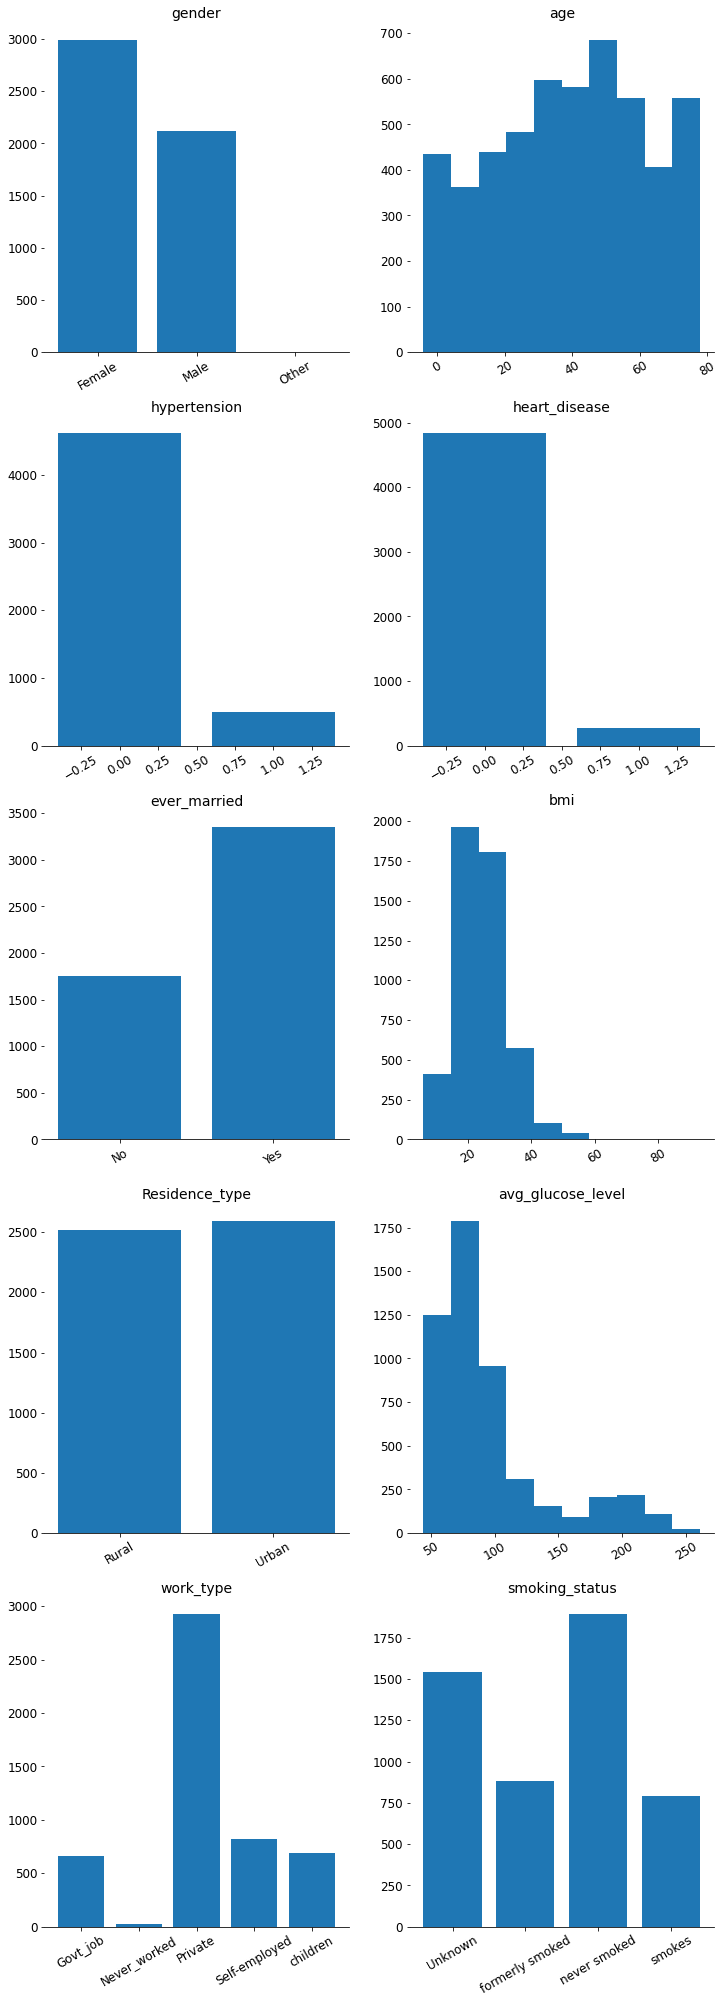

In [7]:
fig, axs = plt.subplots(5, 2, figsize = (12, 35))

for key, item in axxxs.items():
    plt.sca(axs[item[0], item[1]]); ax = plt.gca()
    item[2](key, ax)

### Datos procesados

Cargamos los datos tras haberles hecho una limpieza en otro notebook:

In [8]:
# Leer los datos, pasarlos a pandas
datos = pd.read_csv("../Datos/Stroke_Data.csv")

# Imprimirlos para saber con que trabajamos
datos

,stroke,gender,age,hypertension,heart_disease,ever_married,Residence_type,avg_glucose_level,bmi,smoking_status
0,1,1,67.0,0,1,1,1,228.69,36.6,2
1,1,1,80.0,0,1,1,0,105.92,32.5,0
2,1,0,49.0,0,0,1,1,171.23,34.4,3
3,1,0,79.0,1,0,1,0,174.12,24.0,0
4,1,1,81.0,0,0,1,1,186.21,29.0,2
...,...,...,...,...,...,...,...,...,...,...
4904,0,0,13.0,0,0,0,0,103.08,18.6,1
4905,0,0,81.0,0,0,1,1,125.20,40.0,0
4906,0,0,35.0,0,0,1,0,82.99,30.6,0
4907,0,1,51.0,0,0,1,0,166.29,25.6,2


In [9]:
# Cambiamos los datos a un array de numpy pata poder trabajar con ellos. 
datos_array = np.asarray(datos)

In [10]:
# Tomamos la variable objetivo, en este caso, esta es `stroke`
y = datos_array[:, 0].astype('float64')

# Tomamos el resto de las variables como variables explicativas, y agregamos un
# intercepto
X = np.asarray(datos_array[:, 1:]).astype('float64')
intercept = np.ones(X.shape[0]).reshape(X.shape[0], 1)
X = np.concatenate((intercept, X), axis = 1)
X

array([[  1.  ,   1.  ,  67.  , ..., 228.69,  36.6 ,   2.  ],
       [  1.  ,   1.  ,  80.  , ..., 105.92,  32.5 ,   0.  ],
       [  1.  ,   0.  ,  49.  , ..., 171.23,  34.4 ,   3.  ],
       ...,
       [  1.  ,   0.  ,  35.  , ...,  82.99,  30.6 ,   0.  ],
       [  1.  ,   1.  ,  51.  , ..., 166.29,  25.6 ,   2.  ],
       [  1.  ,   0.  ,  44.  , ...,  85.28,  26.2 ,   1.  ]])

## Definición de funciones que ocuparemos en la optimización

#### Función de costo
$$ \mathcal{c}(\beta) =\Sigma{-y\cdot \beta \cdot x + y\cdot log(h) + (1-y)\cdot log(h)}$$

$$ \text{con: } h = h(\beta) = e^{\beta x}$$

#### Función logit
$$ \mathcal{l}(\beta) = \frac{1}{1 + e^{-\beta x}}$$


#### Función de score
$$ \mathcal{s}(\beta) = x^T \cdot (\mathcal{l}(\beta) - y) $$

In [11]:
# Función de costo
def cost(beta, X=X, y=y):
    # Por simplicidad resumimos los términos
    h = np.exp(np.dot(X, beta)) 
    log_h = np.log(1.0 + h)
    
    # Regresamos la función de costo según la definimos arriba
    return np.sum(-y*np.dot(X, beta) + y*log_h + (1-y)*log_h)

# Función logit
def logit(X, beta):
    return 1/(1.0 + np.exp(-np.dot(X, beta)))

# Función de score
def score(beta, X=X, y=y):
    return np.dot(X.T, logit(X, beta) - y)

## Implementación de BFGS

In [12]:
def bfgs(f, gradiente, x_init, tol=1e-6, return_all = False):
    """
    Cálculo de aproximación numérica de mínimo de una función por el método de BFGS.
    Se usa búsqueda de línea de el paquete scipy. 
    Args:
    
        f (function): función a la cual aproximar el mínimo.
        
        gradiente (function): Expresión para el gradiente de f.
        
        x_init (np.array): Punto inicial del cual seguirá el método.
        
        tol (float): Tolerancia para el problema.
        
        return_all (bool) : Si es TRUE, regresa las x_k para cada k. Si no, sólo la última.
        
    Regresa:
    
        xk (np.array): Valor final de la aproximación. 

        k (integer): Número de iteraciones. 
    """
    # Diccionario que guarda los resultados de cada iteración
    resultados = dict()
    
    # Se inicializa el número de iteraciones
    k = 0

    # Se inicializa el gradiente
    grad_k = gradiente(x_init)

    # Se calcula el tamaño necesario para la Hessiana `Hess`, dependiendo del tamaño 
    # del vector x_init. Se inicializa como la identidad. 
    n = len(x_init)
    Hess = np.eye(n)
    B_k = np.eye(n)

    # Inicialización del vector solución. 
    x_k = x_init

    # Inicializamos alfa
    alfa = 0.001

    while np.linalg.norm(grad_k,2) > tol and k < 2000:
        # pk: Aproximación a la dirección de descenso por Newton. 
        p_k = -np.dot(Hess, grad_k)

        # Busqueda de línea de scipy. Regresa varias cosas, pero solamente nos 
        # interesa el primer término, alfa. 
        alfa = sp.optimize.line_search(f, gradiente, x_k, p_k)[0]
        if alfa == None: 
            alfa = 0.01

        # Creando nueva x para siguiente iteración. 
        x_new = x_k + alfa * p_k
        
        # Calculamos `s` y `y` para la iteración k, y actualizamos x y el gradiente
        s_k = x_new - x_k
        x_k = x_new
        grad_new = gradiente(x_new)
        y_k = grad_new - grad_k
        grad_k = grad_new
        
        # Cálculo de la Aproximación con Sherman-Morrison-Woodbury
        B_k = B_k - ((B_k @ s_k) @ (s_k.transpose()  @ B_k))/(s_k.transpose() @ B_k @ s_k) + (np.outer(y_k, y_k))/(y_k.transpose() @ s_k)

        # Actualización de la aproximación a la Hessiana
        rho_k = 1.0 / (y_k.transpose() @ s_k)
        A1 = np.eye(n) - rho_k * np.outer(s_k, y_k)
        A2 = np.eye(n) - rho_k * np.outer(y_k, s_k)
        Hess = A1 @ (Hess @ A2) + (rho_k * np.outer(s_k,s_k))
        
        # Vamos guardando los valores
        resultados[k] = (x_k, k)
        
        # Subimos el número de iteraciones
        k += 1
    
    if return_all:
        return resultados
    else:
        return (x_k, k-1)
     

## scipy vs implementación

Comparamos el paquete de **scipy** vs nuestra implementación:

In [13]:
# Optimización con BFGS a través de scipy
sol_scipy_bfgs = sp.optimize.minimize(fun = cost,
                                      x0 = np.ones(10)*0.5, 
                                      method = 'BFGS',
                                      args = (X,y),
                                      jac = score)

<ipython-input-11-a25d2f5078ff>:4: RuntimeWarning: overflow encountered in exp
  h = np.exp(np.dot(X, beta))
<ipython-input-11-a25d2f5078ff>:8: RuntimeWarning: invalid value encountered in multiply
  return np.sum(-y*np.dot(X, beta) + y*log_h + (1-y)*log_h)
<ipython-input-11-a25d2f5078ff>:12: RuntimeWarning: overflow encountered in exp
  return 1/(1.0 + np.exp(-np.dot(X, beta)))


In [14]:
# Optimización con BFGS implementado manualmente
result, _ = bfgs(f = cost, 
                 gradiente = score , 
                 x_init = np.ones(10)*0.5)

c:\users\mike\appdata\local\programs\python\python39\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
<ipython-input-11-a25d2f5078ff>:12: RuntimeWarning: overflow encountered in exp
  return 1/(1.0 + np.exp(-np.dot(X, beta)))
<ipython-input-11-a25d2f5078ff>:4: RuntimeWarning: overflow encountered in exp
  h = np.exp(np.dot(X, beta))
<ipython-input-11-a25d2f5078ff>:8: RuntimeWarning: invalid value encountered in multiply
  return np.sum(-y*np.dot(X, beta) + y*log_h + (1-y)*log_h)


#### Comparación de coeficientes

Vemos que los coeficientes resultantes son prácticamente idénticos. Y con una tolerancia de $1e-5$ son idénticos:

In [15]:
sol_scipy_bfgs.x

array([-7.87099875e+00, -1.85502456e-02,  6.87997371e-02,  5.42168790e-01,
        3.73328055e-01, -1.08265612e-01,  1.08427557e-02,  4.76587531e-03,
        3.59973058e-03,  1.05642791e-01])

In [16]:
result

array([-7.87099875e+00, -1.85502512e-02,  6.87997372e-02,  5.42168789e-01,
        3.73328069e-01, -1.08265603e-01,  1.08427521e-02,  4.76587528e-03,
        3.59973049e-03,  1.05642789e-01])

In [17]:
np.allclose(sol_scipy_bfgs.x, result, rtol = 1e-5)

True

#### Resultados en cada iteración

In [18]:
# Optimización con BFGS implementado manualmente, regresando todos los resultados
resultados = bfgs(f = cost, 
                 gradiente = score , 
                 x_init = np.ones(10)*0.5,
                 return_all = True)

<ipython-input-11-a25d2f5078ff>:12: RuntimeWarning: overflow encountered in exp
  return 1/(1.0 + np.exp(-np.dot(X, beta)))
<ipython-input-11-a25d2f5078ff>:4: RuntimeWarning: overflow encountered in exp
  h = np.exp(np.dot(X, beta))
<ipython-input-11-a25d2f5078ff>:8: RuntimeWarning: invalid value encountered in multiply
  return np.sum(-y*np.dot(X, beta) + y*log_h + (1-y)*log_h)


La cantidad de iteraciones para el nivel de tolerancia dado fue:

In [19]:
N_iter = len(resultados)
N_iter

86

Concatenamos todos los coeficientes de cada iteración en un solo DataFrame:

In [20]:
N_coeficientes = pd.concat([pd.DataFrame(resultados[k][0], columns = [k]) for k in range(N_iter)], 1)

Obtuvimos la cantidad de iteraciones y el valor de los coeficientes en cada iteración. El algoritmo corrió en  un total de 86 iteraciones. Las primeras 10 se ven así, todas  bastante variables pues están lejos de converger:

Las primeras 10 iteraciones se ven así, todas  bastante variables pues están lejos de converger:

In [21]:
N_coeficientes.iloc[:,:10]

,0,1,2,3,4,5,6,7,8,9
0,-46.5000,-290.732689,-464.306964,-826.301000,-909.831768,-889.266352,-922.489562,-953.455763,-1020.717556,-1159.354542
1,-18.7200,-105.250628,-156.582876,-259.805377,-279.378474,-251.025445,-253.408073,-247.116231,-220.607885,-158.002434
2,-1962.2412,8330.259798,8901.227252,7344.848175,6406.608587,3310.174723,3818.581288,4513.903041,4024.597078,2440.901161
3,-3.4100,137.260987,206.401828,337.859205,374.314668,398.094049,425.724289,463.533021,547.940819,736.100792
4,-1.5300,104.935130,157.821973,258.054627,281.096204,280.440737,298.589527,321.065340,365.246762,461.129760
5,-29.6800,9.170789,-16.570633,-92.998249,-112.262722,-116.644721,-114.775945,-105.985358,-97.241222,-77.386967
6,-23.3100,-135.244457,-220.037174,-396.323832,-440.857358,-455.058134,-472.971806,-491.146205,-545.208836,-665.938598
7,-4887.6756,-6152.923774,-4668.111246,-613.827139,422.902116,845.513549,815.479769,484.996697,398.779702,231.017144
8,-1354.1840,-7092.296601,-10850.171685,-18507.795710,-19833.310679,-17217.063590,-17188.934614,-16201.783555,-13639.337567,-7485.089931
9,-50.5800,-191.882472,-305.868401,-548.050200,-602.478716,-558.910044,-557.587595,-541.157707,-495.564126,-391.880275


Las últimas 10 iteraciones se ven así, en las que prácticamente ya no hay variación:

In [22]:
N_coeficientes.iloc[:,-10:]

,76,77,78,79,80,81,82,83,84,85
0,-7.870803,-7.871033,-7.870989,-7.870997,-7.870998,-7.870999,-7.870999,-7.870999,-7.870999,-7.870999
1,-0.018643,-0.018504,-0.018560,-0.018551,-0.018550,-0.018550,-0.018550,-0.018550,-0.018550,-0.018550
2,0.068795,0.068800,0.068800,0.068800,0.068800,0.068800,0.068800,0.068800,0.068800,0.068800
3,0.542177,0.542163,0.542169,0.542169,0.542169,0.542169,0.542169,0.542169,0.542169,0.542169
4,0.373275,0.373327,0.373340,0.373327,0.373328,0.373328,0.373328,0.373328,0.373328,0.373328
5,-0.108041,-0.108292,-0.108272,-0.108264,-0.108266,-0.108266,-0.108266,-0.108266,-0.108266,-0.108266
6,0.010900,0.010855,0.010838,0.010843,0.010843,0.010843,0.010843,0.010843,0.010843,0.010843
7,0.004766,0.004766,0.004766,0.004766,0.004766,0.004766,0.004766,0.004766,0.004766,0.004766
8,0.003600,0.003600,0.003600,0.003600,0.003600,0.003600,0.003600,0.003600,0.003600,0.003600
9,0.105666,0.105643,0.105643,0.105643,0.105643,0.105643,0.105643,0.105643,0.105643,0.105643


Graficamos para ver como los coeficientes van convergiendo:

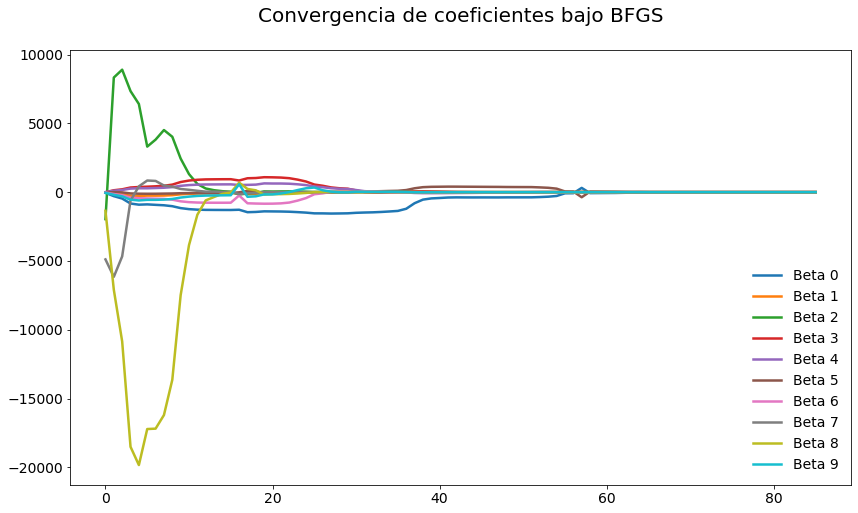

In [23]:
fig, ax = plt.subplots(figsize = (14,8))

for coef in range(len(N_coeficientes)):
    ax.plot(N_coeficientes.loc[coef], label = f'Beta {coef}', linewidth = 2.5);

ax.tick_params(labelsize = 14)
plt.legend(loc = 'lower right', frameon = False, fontsize = 14)
plt.title('Convergencia de coeficientes bajo BFGS', fontsize = 20, y=1.05)
plt.savefig(path_for_imgs + 'convergencia_coefs.png', bbox_inches='tight')

Vamos haciendo zoom progresivo para apreciar como se van reduciendo los coeficientes:

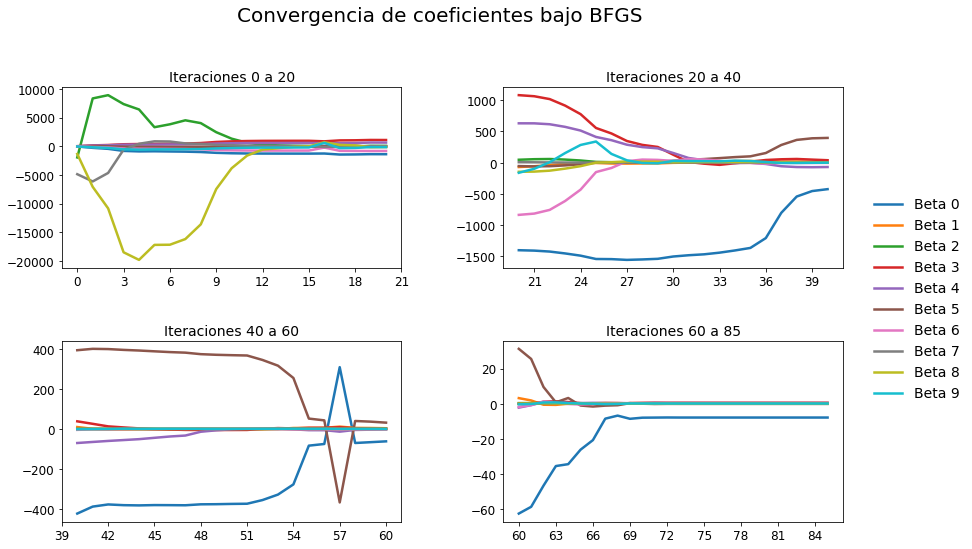

In [24]:
fig, axs = plt.subplots(2, 2, figsize = (14,8))
plt.subplots_adjust(wspace=0.3, hspace=0.4)

cutoffs = [0, 20, 40, 60, N_coeficientes.columns[-1]]
axxs = [[0,0], [0,1], [1,0], [1,1]]

for k in range(4):
    plt.sca(axs[axxs[k][0], axxs[k][1]]); ax = plt.gca()

    for coef in range(len(N_coeficientes)):
        ax.plot(N_coeficientes.loc[coef, cutoffs[k]:cutoffs[k+1]], label = f'Beta {coef}', linewidth = 2.5);
    
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax.tick_params(labelsize = 12)
    ax.set_title(f'Iteraciones {cutoffs[k]} a {cutoffs[k+1]}', fontsize = 14)

plt.legend(loc = 'lower right', frameon = False, fontsize = 14, bbox_to_anchor = (1.38,0.6))
plt.suptitle('Convergencia de coeficientes bajo BFGS', fontsize = 20, y=1.02)
plt.savefig(path_for_imgs + 'convergencia_coefs_iters.png', bbox_inches='tight')

Podría además interesarnos como cambia el error relativo entre cada iteración:

In [25]:
temp = N_coeficientes.transpose()
temp = (temp - temp.shift())/temp.shift()
err_rel = temp.transpose().iloc[:,1:]

Las primeras 10 iteraciones se ven así, donde observamos que los errores relativos son considerablemente altos, en particular en la primera  iteración:

In [26]:
err_rel.iloc[:,:10]

,1,2,3,4,5,6,7,8,9,10
0,5.252316,0.597024,0.779644,0.101090,-0.022604,0.037360,0.033568,0.070545,0.135823,0.064867
1,4.622363,0.487714,0.659220,0.075338,-0.101486,0.009492,-0.024829,-0.107271,-0.283786,-0.233235
2,-5.245278,0.068541,-0.174850,-0.127741,-0.483319,0.153589,0.182089,-0.108400,-0.393504,-0.463324
3,-41.252489,0.503718,0.636900,0.107901,0.063528,0.069406,0.088810,0.182097,0.343395,0.144271
4,-69.585052,0.503996,0.635099,0.089290,-0.002332,0.064715,0.075273,0.137609,0.262516,0.116406
5,-1.308989,-2.806893,4.612233,0.207149,0.039033,-0.016021,-0.076589,-0.082503,-0.204175,-0.134136
6,4.801993,0.626959,0.801168,0.112367,0.032212,0.039366,0.038426,0.110074,0.221438,0.090993
7,0.258865,-0.241318,-0.868506,-1.688960,0.999313,-0.035521,-0.405262,-0.177768,-0.420690,-0.260313
8,4.237321,0.529853,0.705761,0.071619,-0.131912,-0.001634,-0.057429,-0.158158,-0.451213,-0.485969
9,2.793643,0.594040,0.791784,0.099313,-0.072316,-0.002366,-0.029466,-0.084252,-0.209224,-0.173521


Las últimas 10 iteraciones se ven así, en las que prácticamente ya no hay variación:

In [27]:
err_rel.iloc[:,-10:]

,76,77,78,79,80,81,82,83,84,85
0,0.000004,0.000029,-0.000006,9.193655e-07,2.352146e-07,3.428047e-08,-2.290013e-11,-1.298498e-09,-1.001359e-12,-8.434142e-11
1,-0.022255,-0.007443,0.003023,-4.798765e-04,-3.616088e-05,-3.552646e-06,-1.619369e-09,-2.565481e-07,9.447859e-11,8.646545e-09
2,-0.000231,0.000079,-0.000008,2.768727e-07,4.060031e-07,2.934493e-08,1.631314e-10,1.014973e-08,1.209672e-12,1.067823e-10
3,-0.000009,-0.000025,0.000011,-2.119425e-07,-1.179150e-07,6.407884e-08,-2.982007e-11,-5.853034e-09,5.456215e-12,4.661675e-10
4,0.000049,0.000139,0.000034,-3.287634e-05,2.040107e-06,-2.685347e-08,-2.062371e-09,-1.526218e-07,4.726346e-12,4.063030e-10
5,-0.007052,0.002324,-0.000183,-7.670229e-05,1.524361e-05,-7.288615e-07,2.929204e-09,1.883344e-07,1.662890e-11,1.343452e-09
6,0.029246,-0.004121,-0.001561,4.846680e-04,-5.592511e-05,-1.127621e-06,-1.682576e-08,-9.947125e-07,-2.134592e-11,-2.494697e-09
7,-0.000794,-0.000036,0.000090,-1.623622e-05,1.144548e-06,1.211513e-07,1.413429e-10,4.384329e-09,-2.297859e-12,-1.665993e-10
8,0.005558,0.000087,-0.000205,3.829347e-05,4.507381e-06,1.027110e-06,-6.220669e-09,-3.909404e-07,-7.089647e-11,-6.152762e-09
9,0.001757,-0.000221,0.000004,-2.020494e-06,8.093769e-07,-6.684350e-07,2.479607e-09,1.912689e-07,-1.251464e-11,-1.143459e-09


Graficamos para ver como se comportan los errores relativos de cada coeficiente. Es interesante notar que, aunque haya picos, no necesariamente significa que este mal, sino que fueron puntos de cambio importantes en que los coeficientes se ajustaron para converger:

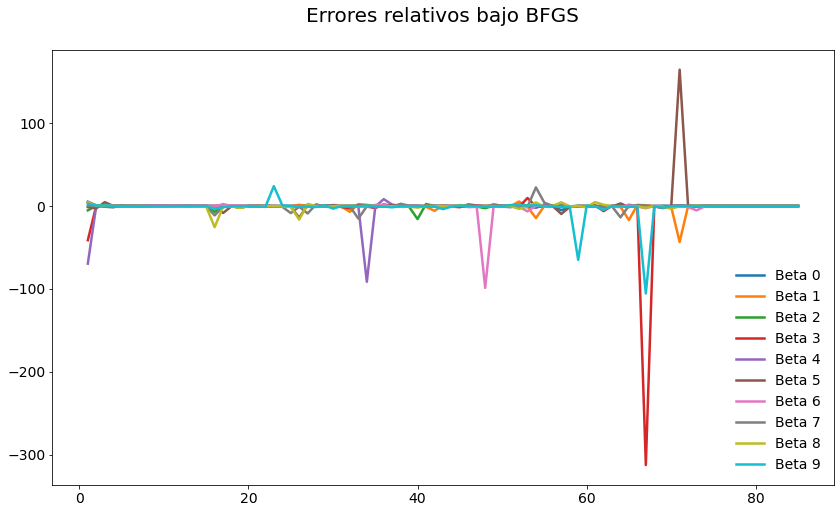

In [28]:
fig, ax = plt.subplots(figsize = (14,8))

for coef in range(len(N_coeficientes)):
    ax.plot(err_rel.loc[coef], label = f'Beta {coef}', linewidth = 2.5);

ax.tick_params(labelsize = 14)
plt.legend(loc = 'lower right', frameon = False, fontsize = 14)
plt.title('Errores relativos bajo BFGS', fontsize = 20, y=1.05)
plt.savefig(path_for_imgs + 'err_rel_coefs.png', bbox_inches='tight')

Vamos haciendo zoom progresivo:

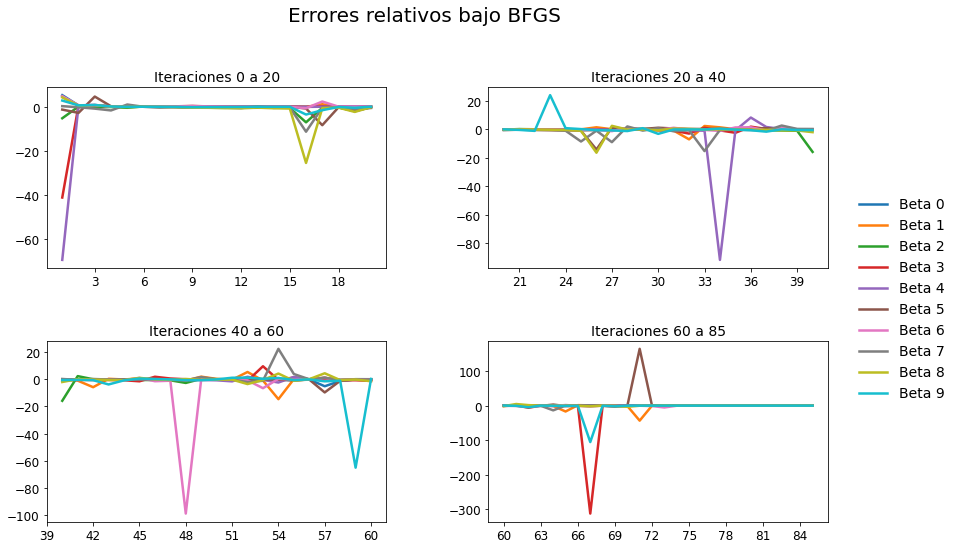

In [30]:
fig, axs = plt.subplots(2, 2, figsize = (14,8))
plt.subplots_adjust(wspace=0.3, hspace=0.4)

cutoffs = [0, 20, 40, 60, err_rel.columns[-1]]
axxs = [[0,0], [0,1], [1,0], [1,1]]

for k in range(4):
    plt.sca(axs[axxs[k][0], axxs[k][1]]); ax = plt.gca()

    for coef in range(len(err_rel)):
        ax.plot(err_rel.loc[coef, cutoffs[k]:cutoffs[k+1]], label = f'Beta {coef}', linewidth = 2.5);
    
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax.tick_params(labelsize = 12)
    ax.set_title(f'Iteraciones {cutoffs[k]} a {cutoffs[k+1]}', fontsize = 14)

plt.legend(loc = 'lower right', frameon = False, fontsize = 14, bbox_to_anchor = (1.38,0.6))
plt.suptitle('Errores relativos bajo BFGS', fontsize = 20, y=1.02)
plt.savefig(path_for_imgs + 'err_rel_coefs_iters.png', bbox_inches='tight')

## Predicciones

Predecimos algunos valores con los coeficientes calculados:

In [54]:
coefs = pd.concat([pd.Series(datos.columns), N_coeficientes.iloc[:,-1]], 1)
coefs.columns = ['Variable', 'Coeficiente']
coefs.at[0,'Variable'] = 'Intercept'
coefs.set_index('Variable', inplace = True)
coefs

,Coeficiente
Variable,
Intercept,-7.870999
gender,-0.018550
age,0.068800
hypertension,0.542169
heart_disease,0.373328
ever_married,-0.108266
Residence_type,0.010843
avg_glucose_level,0.004766
bmi,0.003600


### Caso 1

#### Nueva observación

In [80]:
new_X = pd.DataFrame(
            pd.Series(
                {
                'Intercept':             1.00,
                'gender':                1.00,
                'age':                  25.00,
                'hypertension':          0.00,
                'heart_disease':         0.00,
                'ever_married':          0.00,
                'Residence_type':        1.00,
                'avg_glucose_level':    130.56,
                'bmi':                  22.10,
                'smoking_status':        3.00,
                }
            ), columns = ['X']
        )
new_X

,X
Intercept,1.00
gender,1.00
age,25.00
hypertension,0.00
heart_disease,0.00
ever_married,0.00
Residence_type,1.00
avg_glucose_level,130.56
bmi,22.10
smoking_status,3.00


#### Predicción

In [81]:
pred = 1/(1 + np.exp(-1 * coefs.T @ new_X))
print(f'La probabilidad de tener un derrame es: {np.round(100*pred.iloc[0,0],2)}%')

La probabilidad de tener un derrame es: 0.58%


### Caso 2

#### Nueva observación

In [72]:
new_X = pd.DataFrame(
            pd.Series(
                {
                'Intercept':             1.00,
                'gender':                0.00,
                'age':                  82.00,
                'hypertension':          1.00,
                'heart_disease':         1.00,
                'ever_married':          0.00,
                'Residence_type':        1.00,
                'avg_glucose_level':    320.56,
                'bmi':                  22.10,
                'smoking_status':        3.00,
                }
            ), columns = ['X']
        )
new_X

,X
Intercept,1.00
gender,0.00
age,82.00
hypertension,1.00
heart_disease,1.00
ever_married,0.00
Residence_type,1.00
avg_glucose_level,320.56
bmi,22.10
smoking_status,3.00


#### Predicción

In [78]:
pred = 1/(1 + np.exp(-1 * coefs.T @ new_X))
print(f'La probabilidad de tener un derrame es: {np.round(100*pred.iloc[0,0],2)}%')

La probabilidad de tener un derrame es: 65.05%
